In [86]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.feature_selection import f_classif


## NYT sentiment

In [89]:
# company names - current
comp_names = ['21st-Century-Fox', 'AT&T', 'CBS', 'Comcast', 'Verizon']

In [90]:
sent_nyt = dict()

for comp in comp_names:
    f = glob.glob('NYT_sentiment_data/'+comp+'*.csv')
    df = pd.read_csv(f[0])
    df = df.drop(['Unnamed: 0', 'level_0', 'index'], axis=1)
    df = df.drop(['Modal', 'Negative', 'Positive', 'Uncertainty', 
                  'Litigious', 'Constraining', 'Superfluous',
                  'Interesting', 'Doc_length', 'Positive_score'], axis=1)
    # change dta to datetime 
    df.date = pd.to_datetime(df.date)
    # set index to date
    df = df.set_index('date')

    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-12-03')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)    
    #filter dates between 2008-01-01 to 2018-08-31
    df = df.loc['2008-01-01':'2018-08-31']
    # resample daily take mean if more news in a day, forward fill
    df = df.resample('1D').mean().ffill()
    columns = df.columns
    # rolling average of 90 days
    for col in columns:
        df['90D_roll_'+col] = df[col].rolling(window=90, min_periods=1).mean()
    sent_nyt[comp] = df


In [37]:
sent_nyt['21st-Century-Fox']

,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,90D_roll_compounds_head_summ,90D_roll_Modal_freq,90D_roll_Negative_freq,90D_roll_Positive_freq,90D_roll_Uncertainty_freq,90D_roll_Litigious_freq,90D_roll_Constraining_freq,90D_roll_Superfluous_freq,90D_roll_Interesting_freq,90D_roll_Negative_score
date,,,,,,,,,,,,,,,,,,,,,
2008-01-10,0.00000,0.0000,0.0000,0.142857,0.000000,0.000000,0.071429,0.000000,0.0,0.0,...,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-11,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.114286,0.014286,0.014286,0.064286,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-12,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.104762,0.019048,0.019048,0.061905,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-13,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.100000,0.021429,0.021429,0.060714,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-14,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.097143,0.022857,0.022857,0.060000,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-15,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.095238,0.023810,0.023810,0.059524,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-16,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.093878,0.024490,0.024490,0.059184,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-17,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.092857,0.025000,0.025000,0.058929,0.000000,0.00000,0.0,0.000000e+00,0.000000
2008-01-18,0.00000,0.0000,0.0000,0.085714,0.028571,0.028571,0.057143,0.000000,0.0,0.0,...,0.000000,0.092063,0.025397,0.025397,0.058730,0.000000,0.00000,0.0,0.000000e+00,0.000000


In [38]:
print (len(sent_nyt['21st-Century-Fox'].columns))
sent_nyt['21st-Century-Fox'].iloc[0]

24


compounds_head                  0.000000
compounds_summ                  0.000000
compounds_head_summ             0.000000
Modal_freq                      0.142857
Negative_freq                   0.000000
Positive_freq                   0.000000
Uncertainty_freq                0.071429
Litigious_freq                  0.000000
Constraining_freq               0.000000
Superfluous_freq                0.000000
Interesting_freq                0.000000
Negative_score                  0.000000
90D_roll_compounds_head         0.000000
90D_roll_compounds_summ         0.000000
90D_roll_compounds_head_summ    0.000000
90D_roll_Modal_freq             0.142857
90D_roll_Negative_freq          0.000000
90D_roll_Positive_freq          0.000000
90D_roll_Uncertainty_freq       0.071429
90D_roll_Litigious_freq         0.000000
90D_roll_Constraining_freq      0.000000
90D_roll_Superfluous_freq       0.000000
90D_roll_Interesting_freq       0.000000
90D_roll_Negative_score         0.000000
Name: 2008-01-10

## Sec sentiment

In [39]:
sec_names = ['fox', 'att', 'cbs', 'comcast', 'verizon']
sec_map = dict(zip(sec_names, comp_names))
print(sec_map)

sent_sec = dict()
for sec_comp in sec_names:
    df = pd.read_csv('sentiment/'+sec_comp+'_sentiment.csv')
    df = df.drop(['Unnamed: 0', 'form','Sentiment'], axis=1)
    df = df.sort_values(by=['findexdate'])
    df.findexdate = pd.to_datetime(df.findexdate)
    df = df.set_index('findexdate')
    
    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-08-31')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)
    
    #filter dates between 2008-01-01 to 2018-08-31
    df = df.loc['2008-01-01':'2018-08-31']    
 

    col_map = dict()
    for col in df.columns:
        col_map[col] = 'SEC_' + col

    df = df.rename(index=str, columns=col_map)
    columns = df.columns
    # calc rolling avg
    for col in columns:
        df['90D_roll_'+col] = df[col].rolling(window=90, min_periods=1).mean()
        
                
    #combine sec sentiment with NYT sentiment    
    sent_sec[sec_map[sec_comp]] = df
    sent_nyt[sec_map[sec_comp]] = sent_nyt[sec_map[sec_comp]].join(df, on=None, how='right')
    sent_nyt[sec_map[sec_comp]] = sent_nyt[sec_map[sec_comp]].fillna(value=0)
    sent_nyt[sec_map[sec_comp]].index.name='fdate'

    

    

{'fox': '21st-Century-Fox', 'att': 'AT&T', 'cbs': 'CBS', 'comcast': 'Comcast', 'verizon': 'Verizon'}


In [28]:
print (len(sent_nyt['21st-Century-Fox'].columns))
sent_nyt['21st-Century-Fox'].iloc[0]


42


compounds_head                    0.000000
compounds_summ                    0.000000
compounds_head_summ               0.000000
Modal_freq                        0.000000
Negative_freq                     0.000000
Positive_freq                     0.000000
Uncertainty_freq                  0.000000
Litigious_freq                    0.000000
Constraining_freq                 0.000000
Superfluous_freq                  0.000000
Interesting_freq                  0.000000
Negative_score                    0.000000
90D_roll_compounds_head           0.000000
90D_roll_compounds_summ           0.000000
90D_roll_compounds_head_summ      0.000000
90D_roll_Modal_freq               0.000000
90D_roll_Negative_freq            0.000000
90D_roll_Positive_freq            0.000000
90D_roll_Uncertainty_freq         0.000000
90D_roll_Litigious_freq           0.000000
90D_roll_Constraining_freq        0.000000
90D_roll_Superfluous_freq         0.000000
90D_roll_Interesting_freq         0.000000
90D_roll_Ne

## 8-k categorical event type 

In [42]:
#read updated_category.csv 
import datetime 
df_cat = pd.read_csv('updated_category.csv', sep='|', encoding='utf-8')
df_cat = df_cat.drop(['Unnamed: 0', 'sec_full_path', 'form'], axis=1)
df_cat['fdate'] =  pd.to_datetime(df_cat['fdate'])
#select data from 2008-01-01 to 2018--8-31
df_cat = df_cat[(df_cat['fdate']>="2008-01-01") & (df_cat['fdate']<="2018-08-31")]


In [43]:
for cik in df_cat.cik.unique():
    df_temp = df_cat[df_cat.cik==cik]
    
    print(cik, df_temp.coname.unique())
    
    
cik_map = {732712: 'Verizon',
           1166691: 'Comcast',
           813828: 'CBS',
           732717: 'AT&T',
           1308161: '21st-Century-Fox'}
df_cat['comp_name'] = df_cat.cik.map(lambda x: cik_map[x])
df_cat = df_cat.drop(['cik', 'coname'], axis=1)
#df_cat.fdate = pd.to_datetime(df_cat.fdate)
# get dummies for the item categories
dum = pd.get_dummies(df_cat.updated_item_category_splited_v2)

df_cat = pd.concat([df_cat, dum], axis=1)
#group by date
df_cat = df_cat.groupby(['fdate','comp_name'], as_index=False).agg('sum')
#add total number of event type from each 8k as feature
df_cat['number_of_events'] = df_cat[df_cat.columns].sum(axis=1)
df_cat

732712 ['VERIZON COMMUNICATIONS INC']
1166691 ['COMCAST CORP']
813828 ['CBS CORP']
732717 ['AT&T INC.']
1308161 ['NEWS CORP' 'TWENTY-FIRST CENTURY FOX, INC.']


,fdate,comp_name,Item 1.,Item 1.01,Item 1.02,Item 1.03,Item 2.,Item 2.01,Item 2.02,Item 2.03,...,Item 5.04,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events
0,2008-01-07,21st-Century-Fox,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2
1,2008-01-11,Verizon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,2008-01-28,Verizon,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2008-01-30,Verizon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2008-02-01,AT&T,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2
5,2008-02-04,Comcast,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2008-02-08,Verizon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2008-02-12,21st-Century-Fox,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
8,2008-02-13,Comcast,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
9,2008-02-14,Comcast,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
for comp in comp_names:

    df = df_cat[df_cat.comp_name==comp]
    df = df.set_index('fdate')
    
    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-08-31')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)
    
    #combine categorical event type with sentiments
    sent_nyt[comp] = sent_nyt[comp].join(df, on=None, how='right')
    sent_nyt[comp] = sent_nyt[comp].fillna(value=0)
    sent_nyt[comp] = sent_nyt[comp].drop(['comp_name'],axis=1)

In [45]:
print (len(sent_nyt['21st-Century-Fox'].columns))
sent_nyt['21st-Century-Fox']


70


,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,Item 5.04,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events
2008-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-02-12,0.440400,0.735100,0.844200,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2008-04-16,0.296000,0.255300,0.483250,0.062500,0.031250,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0
2008-05-15,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-16,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-19,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-20,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-21,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-23,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2008-05-27,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


##  stock price

In [14]:
import fix_yahoo_finance as yf
import datetime as dt
# stock prices - from Yahoo finance
tickers = ['FOXA', 'T', 'CBS', 'CMCSA', 'VZ']
start = dt.datetime(1993,1,1)
end = dt.datetime(2018,8,31)
df_stock = yf.download(tickers, start=start, end=end)
print(df_stock.shape, df_stock.dtypes)
# df_stock.tail(3)

[*********************100%***********************]  5 of 5 downloaded
(6465, 30) Open       CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
High       CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Low        CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Close      CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Adj Close  CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Volume     CBS      float64
           CMCSA      int32
           FOXA     float64
           T          int32
           VZ         int32
dtype: object


In [46]:
#stock price daily change number
df_change=(df_stock['Close']-df_stock['Open'])/df_stock['Open']
df_change.index = pd.to_datetime(df_change.index)

In [47]:
print ('total numbr of stock price dates from 1993-01-01 to 2018-08-31 is:', df_change.shape[0])
print (df_change.head())

total numbr of stock price dates from 1993-01-01 to 2018-08-31 is: 6465
            CBS     CMCSA  FOXA         T        VZ
Date                                               
1993-01-04  NaN  0.000000   NaN -0.003413  0.002427
1993-01-05  NaN -0.006410   NaN  0.000000 -0.004950
1993-01-06  NaN  0.032258   NaN  0.012027  0.017370
1993-01-07  NaN -0.006250   NaN -0.001692 -0.007299
1993-01-08  NaN -0.012578   NaN -0.011885 -0.022113


In [48]:
ticker_map = dict(zip(comp_names, tickers))
ticker_map

#combine stock price to current dataframe
for comp in comp_names:
    sent_nyt[comp] = sent_nyt[comp].join(df_change[ticker_map[comp]], on=None, how='left')
    sent_nyt[comp] = sent_nyt[comp].rename( columns={ticker_map[comp]: 'stock_change'})
    sent_nyt[comp].index.name = 'fdate'


In [49]:
print (len(sent_nyt['21st-Century-Fox'].columns))
sent_nyt['21st-Century-Fox']

71


,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events,stock_change
fdate,,,,,,,,,,,,,,,,,,,,,
2008-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.013811
2008-02-12,0.440400,0.735100,0.844200,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-0.007176
2008-04-16,0.296000,0.255300,0.483250,0.062500,0.031250,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.007429
2008-05-15,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.011597
2008-05-16,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.003627
2008-05-19,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.002081
2008-05-20,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.002091
2008-05-21,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.014099
2008-05-23,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.016420


## financial ratio

In [974]:
att_f_ratios = pd.read_csv('att_data_financial.csv',sep='|')
verizon_f_ratios = pd.read_csv('vz_data_financial.csv',sep='|')

In [975]:
att_f_ratios['3 Months Ending']=pd.to_datetime(att_f_ratios['3 Months Ending'])
att_f_ratios=att_f_ratios.set_index('3 Months Ending')
att_daily = att_f_ratios.resample('1D').mean().ffill()

In [977]:
verizon_f_ratios['3 Months Ending']=pd.to_datetime(verizon_f_ratios['3 Months Ending'])
verizon_f_ratios = verizon_f_ratios.set_index('3 Months Ending')
verizon_daily = verizon_f_ratios.resample('1D').mean().ffill()

In [980]:
verizon_daily.tail()

,EBITDA Margin,Operating Margin,5 Year Growth,Total Debt/Capital,Total Debt/T12M EBITDA,EBITDA to Interest Expense
3 Months Ending,,,,,,
2018-09-26,34.0558,20.5478,NaN,68.1509,2.6568,8.9746
2018-09-27,34.0558,20.5478,NaN,68.1509,2.6568,8.9746
2018-09-28,34.0558,20.5478,NaN,68.1509,2.6568,8.9746
2018-09-29,34.0558,20.5478,NaN,68.1509,2.6568,8.9746
2018-09-30,36.9614,23.5379,NaN,66.8181,2.5703,9.9521


In [978]:
att_daily.head()

,EBITDA Margin,Operating Margin,Revenue,Total Debt/Capital,Total Debt/T12M EBITDA,EBITDA to Interest Expense
3 Months Ending,,,,,,
2008-12-31,31.9925,15.7614,25.2867,43.7679,1.7462,12.2288
2009-01-01,31.9925,15.7614,25.2867,43.7679,1.7462,12.2288
2009-01-02,31.9925,15.7614,25.2867,43.7679,1.7462,12.2288
2009-01-03,31.9925,15.7614,25.2867,43.7679,1.7462,12.2288
2009-01-04,31.9925,15.7614,25.2867,43.7679,1.7462,12.2288


## Moody's rating change data

In [50]:
df_moodys = pd.read_csv('Moodys_new_type.csv')
df_moodys = df_moodys.drop(['Unnamed: 0', 'Watch', 'Type', 'delta'], axis=1)
df_moodys['Effective Date'] = pd.to_datetime(df_moodys['Effective Date'])
name_map = dict(zip(df_moodys.Company.unique(), comp_names))
name_map

{'21st Century Fox America': '21st-Century-Fox',
 'AT&T Corp': 'AT&T',
 'CBS Corp': 'CBS',
 'Comcast Corp': 'Comcast',
 'Verizon Communications Inc': 'Verizon'}

In [52]:
x_train_fox=sent_nyt['21st-Century-Fox']
fox_idx=pd.to_datetime(x_train_fox.index.values)
print ('length of fox train data is:',len(fox_idx))
y_train_fox=[]
for i in range(len(fox_idx)):
    if fox_idx[i]<pd.to_datetime('2008-06-11'):
        temp='Baa2'
    elif fox_idx[i]>=pd.to_datetime('2008-06-11'):
        temp='Baa1'


    y_train_fox.append(temp)
print ('length of fox output data is:',len(y_train_fox))


length of fox train data is: 672
length of fox output data is: 672


In [53]:
x_train_fox['company']='21st-Century-Fox'
x_train_fox.reset_index(inplace=True)
x_train_fox.set_index(['fdate','company'], inplace=True)
x_train_fox.tail()

,,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events,stock_change
fdate,company,,,,,,,,,,,,,,,,,,,,,
2018-06-20,21st-Century-Fox,0.0000,0.3021,0.3021,0.083810,0.000000,0.0,0.020000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.010296
2018-06-21,21st-Century-Fox,0.0258,-0.4215,-0.4019,0.130435,0.000000,0.0,0.043478,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.006983
2018-07-13,21st-Century-Fox,-0.3818,0.0772,-0.3182,0.000000,0.000000,0.0,0.000000,0.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.009552
2018-08-07,21st-Century-Fox,0.0000,0.0000,0.0000,0.045455,0.045455,0.0,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.004594
2018-08-31,21st-Century-Fox,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.003759


In [54]:
#add true rating label to ATT based on 'Moodys_new_type.csv'
x_train_att=sent_nyt['AT&T']
att_idx=pd.to_datetime(x_train_att.index.values)
print ('length of att train data is:',len(att_idx))
y_train_att=[]
for i in range(len(att_idx)):
    if att_idx[i]<pd.to_datetime('2013-01-29'):
        temp='A2'
    elif (fox_idx[i]>=pd.to_datetime('2013-01-29')) & (fox_idx[i]<pd.to_datetime('2015-02-02')):
        temp='A3'
    elif (fox_idx[i]>=pd.to_datetime('2015-02-02')) & (fox_idx[i]<pd.to_datetime('2018-06-05')):
        temp='Baa1'
    elif att_idx[i]>=pd.to_datetime('2018-06-05'):
        temp='Baa2'   
   
    y_train_att.append(temp)
print ('length of att output data is:',len(y_train_att))


length of att train data is: 275
length of att output data is: 275


In [55]:
x_train_att['company']='AT&T'
x_train_att.reset_index(inplace=True)
x_train_att.set_index(['fdate','company'], inplace=True)
x_train_att

,,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events,stock_change
fdate,company,,,,,,,,,,,,,,,,,,,,,
2008-02-01,AT&T,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.007776
2008-04-03,AT&T,0.5859,0.3818,0.75060,0.200000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.013247
2008-04-04,AT&T,0.5859,0.3818,0.75060,0.200000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.013080
2008-04-18,AT&T,0.5859,0.3818,0.75060,0.200000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.009506
2008-05-13,AT&T,0.0000,0.0000,0.00000,0.081633,0.000000,0.000000,0.020408,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.003322
2008-11-17,AT&T,-0.3182,-0.7003,-0.79640,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.020132
2008-12-04,AT&T,-0.3182,-0.7003,-0.79640,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.004242
2009-02-03,AT&T,-0.3182,-0.7003,-0.79640,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.002752
2009-04-30,AT&T,0.3612,-0.1779,0.01290,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-0.008130


In [56]:
#add true rating label to CBS based on 'Moodys_new_type.csv'
x_train_cbs=sent_nyt['CBS']
cbs_idx=pd.to_datetime(x_train_cbs.index.values)
print ('length of cbs train data is:',len(cbs_idx))
y_train_cbs=[]
for i in range(len(cbs_idx)):
    if cbs_idx[i]<pd.to_datetime('2011-08-22'):
        temp='Baa3'
    elif cbs_idx[i]>=pd.to_datetime('2011-08-22'):
        temp='Baa2'
    y_train_cbs.append(temp)
print ('length of cbs output data is:',len(y_train_cbs))

length of cbs train data is: 109
length of cbs output data is: 109


In [57]:
x_train_cbs['company']='CBS'
x_train_cbs.reset_index(inplace=True)
x_train_cbs.set_index(['fdate','company'], inplace=True)
x_train_cbs

compounds_head  compounds_summ  compounds_head_summ  \
fdate      company                                                        
2008-02-26 CBS            0.000000        0.363450             0.363450   
2008-04-29 CBS            0.259778        0.284156             0.415222   
2008-06-03 CBS           -0.131850        0.615800             0.406150   
2008-07-31 CBS            0.000000        0.302700             0.302700   
           CBS            0.000000        0.302700             0.302700   
2008-09-22 CBS           -0.624900        0.000000            -0.624900   
2008-09-24 CBS           -0.002800        0.087080             0.109780   
2008-10-15 CBS           -0.250540        0.068640            -0.135300   
2008-10-30 CBS            0.148425       -0.044675             0.081375   
           CBS            0.148425       -0.044675             0.081375   
2009-02-18 CBS            0.000000       -0.223900            -0.223900   
           CBS            0.000000       -0.223900            -0.223900   
2009-05-05 CBS            0.401900        0.659700             0.796400   
2009-06-10 CBS           -0.083467        0.120400             0.036933   
2009-06-23 CBS            0.585900        0.202300             0.680800   
2009-07-29 CBS            0.246950        0.151150             0.186050   
2009-08-06 CBS            0.000000        0.012900             0.012900   
           CBS            0.000000        0.012900             0.012900   
2009-09-18 CBS            0.000000        0.822500             0.822500   
2009-10-02 CBS            0.000000        0.611650             0.611650   
2009-10-14 CBS           -0.025733        0.621667             0.597900   
           CBS           -0.025733        0.621667             0.597900   
2009-10-16 CBS           -0.350633        0.120267             0.044533   
2009-11-05 CBS           -0.542300        0.336700            -0.401700   
           CBS           -0.542300        0.336700            -0.401700   
2010-01-26 CBS            0.151700        0.774250             0.773250   
2010-02-18 CBS            0.229400        0.109600             0.202150   
2010-04-05 CBS           -0.185067        0.335000             0.191867   
2010-05-05 CBS            0.106150        0.390217             0.390583   
           CBS            0.106150        0.390217             0.390583   
...                            ...             ...                  ...   
2014-08-07 CBS            0.202300        0.000000             0.202300   
           CBS            0.202300        0.000000             0.202300   
2014-08-08 CBS           -0.153100        0.526700             0.612400   
2014-08-15 CBS           -0.153100        0.526700             0.612400   
2014-08-19 CBS            0.000000        0.381800             0.381800   
2014-12-12 CBS            0.440400        0.757900             0.855500   
2014-12-17 CBS            0.000000        0.000000             0.000000   
2015-01-12 CBS            0.246950        0.323900             0.523200   
2015-07-10 CBS            0.318200       -0.476700            -0.202300   
2016-07-11 CBS            0.025800       -0.440400            -0.421500   
2016-10-18 CBS            0.000000        0.000000             0.000000   
2017-02-02 CBS            0.401900        0.296000             0.599400   
           CBS            0.401900        0.296000             0.599400   
2017-07-03 CBS            0.000000        0.025800             0.025800   
2017-07-10 CBS            0.000000       -0.340000            -0.340000   
2017-09-13 CBS            0.000000       -0.381800            -0.381800   
2017-10-19 CBS            0.000000        0.648600             0.648600   
           CBS            0.000000        0.648600             0.648600   
2017-11-01 CBS            0.000000       -0.771300            -0.771300   
2017-11-09 CBS            0.000000       -0.771300            -0.771300   
2017-11-13 CBS            0.000000       -0.7

In [58]:
#add true rating label to comcast based on 'Moodys_new_type.csv'

x_train_comcast=sent_nyt['Comcast']
comcast_idx=pd.to_datetime(x_train_comcast.index.values)
print ('length of comcast train data is:',len(comcast_idx))
y_train_comcast=[]
for i in range(len(comcast_idx)):
    if comcast_idx[i]<pd.to_datetime('2009-04-24'):
        temp='Baa2'
    elif (comcast_idx[i]>=pd.to_datetime('2009-04-24')) & (comcast_idx[i]<pd.to_datetime('2013-02-13')):
        temp='Baa1'
    elif (comcast_idx[i]>=pd.to_datetime('2013-02-13')):
        temp='A3'
    y_train_comcast.append(temp)
print ('length of comcast output data is:',len(y_train_comcast)) 



length of comcast train data is: 168
length of comcast output data is: 168


In [59]:
x_train_comcast['company']='Comcast'
x_train_comcast.reset_index(inplace=True)
x_train_comcast.set_index(['fdate','company'], inplace=True)
x_train_comcast

compounds_head  compounds_summ  compounds_head_summ  \
fdate      company                                                        
2008-02-04 Comcast        0.000000         0.87500              0.87500   
2008-02-13 Comcast        0.000000         0.87500              0.87500   
2008-02-14 Comcast        0.000000         0.87500              0.87500   
2008-04-07 Comcast        0.000000         0.47670              0.47670   
2008-05-01 Comcast        0.648600         0.20230              0.72690   
           Comcast        0.648600         0.20230              0.72690   
2008-05-06 Comcast        0.648600         0.20230              0.72690   
2008-05-20 Comcast        0.546000         0.31845              0.73055   
2008-07-30 Comcast        0.000000        -0.44040             -0.44040   
           Comcast        0.000000        -0.44040             -0.44040   
2008-10-03 Comcast        0.000000         0.55740              0.55740   
2008-10-29 Comcast        0.000000        -0.40190             -0.40190   
           Comcast        0.000000        -0.40190             -0.40190   
2008-11-10 Comcast        0.000000         0.31820              0.31820   
2009-02-13 Comcast        0.000000         0.00000              0.00000   
2009-02-25 Comcast        0.000000        -0.52670             -0.52670   
2009-06-17 Comcast        0.257150        -0.55115             -0.34480   
2009-08-06 Comcast        0.000000         0.00000              0.00000   
           Comcast        0.000000         0.00000              0.00000   
2009-11-04 Comcast        0.210750         0.17000              0.28315   
           Comcast        0.210750         0.17000              0.28315   
2010-02-03 Comcast        0.000000         0.77870              0.77870   
2010-02-26 Comcast        0.180600        -0.17440             -0.01640   
2010-03-22 Comcast        0.000000         0.00000              0.00000   
2010-04-28 Comcast        0.000000        -0.22630             -0.22630   
           Comcast        0.000000        -0.22630             -0.22630   
2010-05-24 Comcast       -0.440400        -0.44040             -0.73190   
2010-07-07 Comcast        0.000000         0.20230              0.20230   
2010-07-28 Comcast        0.778300         0.61240              0.89570   
           Comcast        0.778300         0.61240              0.89570   
...                            ...             ...                  ...   
2017-02-15 Comcast        0.000000        -0.36120             -0.36120   
2017-02-23 Comcast        0.000000        -0.36120             -0.36120   
2017-03-14 Comcast        0.340000         0.65970              0.77830   
2017-03-20 Comcast        0.340000         0.65970              0.77830   
2017-04-27 Comcast        0.340000         0.65970              0.77830   
           Comcast        0.340000         0.65970              0.77830   
2017-05-08 Comcast        0.000000         0.63690              0.63690   
2017-06-13 Comcast        0.000000         0.63690              0.63690   
2017-07-27 Comcast       -0.296000         0.27550             -0.02320   
           Comcast       -0.296000         0.27550             -0.02320   
2017-08-07 Comcast        0.000000         0.84620              0.84620   
2017-10-03 Comcast        0.000000         0.84620              0.84620   
2017-10-19 Comcast        0.000000         0.84620              0.84620   
2017-10-26 Comcast        0.153100        -0.19010             -0.11540   
           Comcast        0.153100        -0.19010             -0.11540   
2018-01-24 Comcast       -0.296000         0.70030              0.55740   
2018-02-08 Comcast       -0.296000         0.70030              0.55740   
2018-02-12 Comcast        0.458800         0.00000              0.25000   
2018-02-27 Comcast        0.210575        -0.16875              0.00145   
2018-04-25 Comcast       -0.299700        -0.43360             -0.62165   
           Comcast       -0.299700        -0.

In [60]:
#add true rating label to Verizon based on 'Moodys_new_type.csv'

x_train_verizon=sent_nyt['Verizon']
verizon_idx=pd.to_datetime(x_train_verizon.index.values)
print ('length of verizon train data is:',len(verizon_idx))
y_train_verizon=[]
for i in range(len(verizon_idx)):
    if verizon_idx[i]<pd.to_datetime('2013-09-02'):
        temp='A3'
    elif verizon_idx[i]>=pd.to_datetime('2013-09-02'):
        temp='Baa1'
    y_train_verizon.append(temp)
print ('length of verizon output data is:',len(y_train_verizon)) 


length of verizon train data is: 220
length of verizon output data is: 220


In [61]:
x_train_verizon['company']='Verizon'
x_train_verizon.reset_index(inplace=True)
x_train_verizon.set_index(['fdate','company'], inplace=True)
x_train_verizon.head()

,,compounds_head,compounds_summ,compounds_head_summ,Modal_freq,Negative_freq,Positive_freq,Uncertainty_freq,Litigious_freq,Constraining_freq,Superfluous_freq,...,Item 5.05,Item 5.07,Item 6.,Item 7.,Item 7.01,Item 8.,Item 8.01,Item 9.01,number_of_events,stock_change
fdate,company,,,,,,,,,,,,,,,,,,,,,
2008-01-11,Verizon,-0.0516,0.1027,0.0516,0.000000,0.000000,0.000000,0.0,0.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.014835
2008-01-28,Verizon,0.0000,-0.2960,-0.2960,0.032258,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.021716
2008-01-30,Verizon,0.0000,0.0000,0.0000,0.000000,0.040000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.009839
2008-02-08,Verizon,-0.7003,-0.4215,-0.8225,0.071429,0.035714,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.011132
2008-02-21,Verizon,-0.4404,0.6124,0.2732,0.076923,0.000000,0.038462,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.014493


In [62]:
#combine all trainning data and testing data
x_all=pd.concat([x_train_fox, x_train_att,x_train_cbs,x_train_comcast,x_train_verizon])
y_all=y_train_fox + y_train_att + y_train_cbs + y_train_comcast + y_train_verizon
x_all['rating']=y_all
#drop duplicated value
x_all=x_all.drop_duplicates(subset=['number_of_events','stock_change'], keep='first')
print (len(x_all.columns))
x_all.columns

72


Index(['compounds_head', 'compounds_summ', 'compounds_head_summ', 'Modal_freq',
       'Negative_freq', 'Positive_freq', 'Uncertainty_freq', 'Litigious_freq',
       'Constraining_freq', 'Superfluous_freq', 'Interesting_freq',
       'Negative_score', '90D_roll_compounds_head', '90D_roll_compounds_summ',
       '90D_roll_compounds_head_summ', '90D_roll_Modal_freq',
       '90D_roll_Negative_freq', '90D_roll_Positive_freq',
       '90D_roll_Uncertainty_freq', '90D_roll_Litigious_freq',
       '90D_roll_Constraining_freq', '90D_roll_Superfluous_freq',
       '90D_roll_Interesting_freq', '90D_roll_Negative_score',
       'SEC_Modal_freq', 'SEC_Negative_freq', 'SEC_Positive_freq',
       'SEC_Uncertainty_freq', 'SEC_Litigious_freq', 'SEC_Constraining_freq',
       'SEC_Superfluous_freq', 'SEC_Interesting_freq', 'SEC_Negative_score',
       '90D_roll_SEC_Modal_freq', '90D_roll_SEC_Negative_freq',
       '90D_roll_SEC_Positive_freq', '90D_roll_SEC_Uncertainty_freq',
       '90D_roll_SEC_Liti

In [64]:
#use data before 2018-07-01 as training set, after 2018-07-01 as test set
x_train = x_all.loc[(x_all.index.get_level_values('fdate') <'2018-07-01')]
x_test = x_all.loc[(x_all.index.get_level_values('fdate') >'2018-07-01')]
y_train = x_train.rating.values
y_test = x_test.rating.values
x_train = x_train.drop('rating',axis=1)
x_test = x_test.drop('rating',axis=1)

In [71]:
x_train = x_train.values
x_test = x_test.values
from numpy import *
#replace nan with 0
NaNs_train=isnan(x_train)
x_train[NaNs_train]=0
NaNs_test=isnan(x_test)
x_test[NaNs_test]=0


In [72]:
print ('number of training data:', len(x_train))
print ('number of test data:', len(x_test))


number of training data: 1243
number of test data: 18


In [73]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds,
                         plot_y_label=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    fig = plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, horizontalalignment='center', verticalalignment='center')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    if plot_y_label:
        plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})
    fig.savefig(title+'.png', dpi=500, bbox_inches='tight')
    fig.savefig(title+'.pdf', bbox_inches='tight')

## XGboost

In [74]:
model = XGBClassifier()
model.fit(x_train, y_train)
print (model)

from sklearn.metrics import accuracy_score
y_train_predict = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict)
print ('Accuracy score for training data is:', train_accuracy )

y_test_predict = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict)
print ('Accuracy score for training data is:', test_accuracy)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy score for training data is: 1.0
Accuracy score for training data is: 0.5


<Figure size 432x288 with 0 Axes>

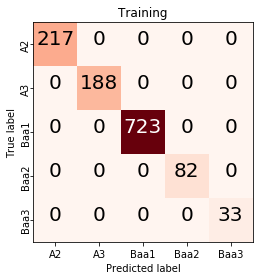

In [75]:
train_cm = confusion_matrix(y_train, y_train_predict)
class_names = list(np.unique(y_train))
fig = plt.figure(); plot_confusion_matrix(train_cm, class_names, title='Training', plot_y_label=True)

In [76]:
test_data=x_all.loc[(x_all.index.get_level_values('fdate') >'2018-07-01')]
test_data['pred_rating']=list(y_test_predict)
test_data=test_data.reset_index()

C:\Users\panba\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
print (y_test)
print (y_test_predict)

['Baa1' 'Baa1' 'Baa1' 'Baa2' 'Baa2' 'Baa2' 'Baa2' 'Baa2' 'Baa2' 'Baa2'
 'Baa2' 'Baa2' 'Baa2' 'A3' 'A3' 'A3' 'A3' 'Baa1']
['Baa1' 'Baa1' 'A2' 'A2' 'Baa2' 'Baa2' 'Baa2' 'Baa2' 'A2' 'Baa1' 'A2' 'A3'
 'A2' 'A3' 'A3' 'A3' 'A2' 'A2']


<Figure size 432x288 with 0 Axes>

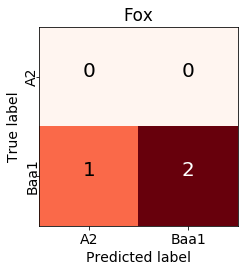

<Figure size 432x288 with 0 Axes>

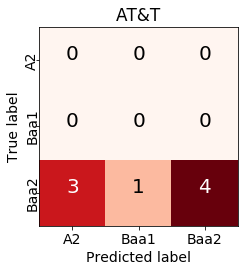

<Figure size 432x288 with 0 Axes>

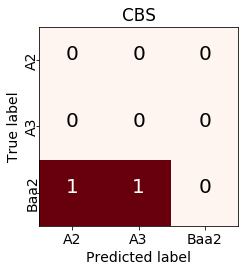

<Figure size 432x288 with 0 Axes>

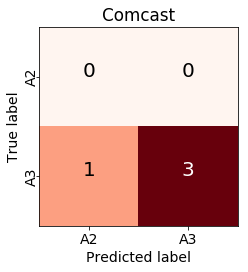

<Figure size 432x288 with 0 Axes>

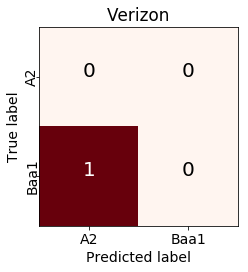

In [93]:
pred_y = []
for com in comp_names:
    
    temp = test_data.loc[test_data['company']==com]  
    y_true = list(temp['rating'])
    y_pred  = list(temp['pred_rating'])
    testing_cm = confusion_matrix(y_true, y_pred)
    class_names = list(np.unique(y_true+y_pred))
    if com == '21st-Century-Fox':
        fig = plt.figure(); plot_confusion_matrix(testing_cm, class_names, title='Fox', plot_y_label=True)
    else:
        fig = plt.figure(); plot_confusion_matrix(testing_cm, class_names, title=com, plot_y_label=True)

    
    

## SVC

In [1195]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300)


model.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
y_train_predict = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict)
print ('Accuracy score for training data is:', train_accuracy )

y_test_predict = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict)
print ('Accuracy score for training data is:', test_accuracy)



Accuracy score for training data is: 1.0
Accuracy score for training data is: 0.2777777777777778
